In [46]:
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from itertools import chain
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database

from secrets import *

In [120]:
# function to fix discrepancies between player names from the two sources
def playername_fix(player):
    if player == 'Nikola Jokic':
        player = 'Nikola Jokić'
    if player == 'Tomas Satoransky':
        player = 'Tomáš Satoranský'
    if player == 'Taurean Prince':
        player = 'Taurean Waller-Prince'
    if player == 'Nikola Vucevic':
        player = 'Nikola Vučević'
    return(player)

In [2]:

dbname = 'cluj'
engine = create_engine('postgres://%s:%s@localhost/%s'%('docker','docker',dbname))

if not database_exists(engine.url):
    create_database(engine.url)
print(database_exists(engine.url))

True


### Pull matchup data

In [4]:
league_id = 84057
url = 'https://fantasy.espn.com/apis/v3/games/FBA/seasons/2020/segments/0/leagues/' + str(league_id)
params={"view": "mBoxscore"}
cookies = {"swid": AUTH['swid'],
           "espn_s2": AUTH['espn_s2']}
r = requests.get(url, params=params, cookies=cookies)
data = r.json()

In [105]:
# if matchup period hasn't started yet, then this doesn't work
# doesn't appear to be an obvious workaround 
teamId = 10
matchupPeriod = 12
team_totals = {}
opponent_totals = {}
for matchup in data['schedule']:
    if ((matchup['away']['teamId'] == teamId) or (matchup['home']['teamId'] == teamId)) & (matchup['matchupPeriodId'] == matchupPeriod):
        
        if matchup['away']['teamId'] == teamId:
            team_role = 'away'
            opponent_role = 'home'
        else:
            team_role = 'home'
            opponent_role = 'away'
        
        team_players = []
        opponent_players = []
        for entry in matchup[team_role]['rosterForCurrentScoringPeriod']['entries']:
            # 12 is bench players if I also want to remove them
            # but have to make sure their lineup is set correctly
            if entry['lineupSlotId'] != 13:
                team_players.append({'fullName':entry['playerPoolEntry']['player']['fullName'],
                                    'proTeamId':entry['playerPoolEntry']['player']['proTeamId']})
        for entry in matchup[opponent_role]['rosterForCurrentScoringPeriod']['entries']:
            if entry['lineupSlotId'] != 13:
                opponent_players.append({'fullName':entry['playerPoolEntry']['player']['fullName'],
                                    'proTeamId':entry['playerPoolEntry']['player']['proTeamId']})

        team_totals['points'] = matchup[team_role]['cumulativeScore']['scoreByStat']['0']['score']
        team_totals['blocks'] = matchup[team_role]['cumulativeScore']['scoreByStat']['1']['score']
        team_totals['steals'] = matchup[team_role]['cumulativeScore']['scoreByStat']['2']['score']
        team_totals['assists'] = matchup[team_role]['cumulativeScore']['scoreByStat']['3']['score']
        team_totals['rebounds'] = matchup[team_role]['cumulativeScore']['scoreByStat']['6']['score']
        team_totals['threes'] = matchup[team_role]['cumulativeScore']['scoreByStat']['17']['score']
        team_totals['fga'] = matchup[team_role]['cumulativeScore']['scoreByStat']['14']['score']
        team_totals['fgm'] = matchup[team_role]['cumulativeScore']['scoreByStat']['13']['score']
        team_totals['fta'] = matchup[team_role]['cumulativeScore']['scoreByStat']['16']['score']
        team_totals['ftm'] = matchup[team_role]['cumulativeScore']['scoreByStat']['15']['score']

        opponent_totals['points'] = matchup[opponent_role]['cumulativeScore']['scoreByStat']['0']['score']
        opponent_totals['blocks'] = matchup[opponent_role]['cumulativeScore']['scoreByStat']['1']['score']
        opponent_totals['steals'] = matchup[opponent_role]['cumulativeScore']['scoreByStat']['2']['score']
        opponent_totals['assists'] = matchup[opponent_role]['cumulativeScore']['scoreByStat']['3']['score']
        opponent_totals['rebounds'] = matchup[opponent_role]['cumulativeScore']['scoreByStat']['6']['score']
        opponent_totals['threes'] = matchup[opponent_role]['cumulativeScore']['scoreByStat']['17']['score']
        opponent_totals['fga'] = matchup[opponent_role]['cumulativeScore']['scoreByStat']['14']['score']
        opponent_totals['fgm'] = matchup[opponent_role]['cumulativeScore']['scoreByStat']['13']['score']
        opponent_totals['fta'] = matchup[opponent_role]['cumulativeScore']['scoreByStat']['16']['score']
        opponent_totals['ftm'] = matchup[opponent_role]['cumulativeScore']['scoreByStat']['15']['score']
        
        break

team_players_df = pd.DataFrame(team_players)
#team_players_df
opponent_players_df = pd.DataFrame(opponent_players)
#opponent_players_df

### Generating simulated data

In [137]:
n_samples = 1000
team_samples = []
opponent_samples = []
start_date = '2020-1-13'
stop_date = '2020-1-19'

# iterate over players
for i in range(len(team_players_df)):

    player = team_players_df.iloc[i]['fullName']
    player = playername_fix(player) # make something better than this
    teamId = team_players_df.iloc[i]['proTeamId']
    print("Processing " + player)
    
    # get player boxscores
    sql = """
        SELECT * FROM boxscores WHERE name = '{}'
    """.format(player)
    player_boxscores = pd.read_sql(sql, engine)
    
    # get n_games for this matchup
    sql = """
        SELECT COUNT(*)
        FROM espn_team_ids eid
        JOIN nba_schedule sch ON eid.scraped_name = sch.home_team OR eid.scraped_name = sch.away_team 
        WHERE espn_team_id = {} AND sch.season_end_year = 2020 AND start_date >= '{}' AND start_date <= '{}'
    """.format(teamId, start_date, stop_date)
    n_games = pd.read_sql(sql, engine).values[0][0]
    print(n_games)

    for sample in range(n_samples):
        player_samples = player_boxscores.sample(replace=False, n=n_games)
        player_samples['sample_i'] = sample
        team_samples.append(player_samples.to_dict('records'))
        
    player = opponent_players_df.iloc[i]['fullName']
    player = playername_fix(player) # make something better than this
    teamId = opponent_players_df.iloc[i]['proTeamId']
    print("Processing " + player)
    
    # get player boxscores
    sql = """
        SELECT * FROM boxscores WHERE name = '{}'
    """.format(player)
    player_boxscores = pd.read_sql(sql, engine)
    
    # get n_games for this matchup
    sql = """
        SELECT COUNT(*)
        FROM espn_team_ids eid
        JOIN nba_schedule sch ON eid.scraped_name = sch.home_team OR eid.scraped_name = sch.away_team 
        WHERE espn_team_id = {} AND sch.season_end_year = 2020 AND start_date >= '{}' AND start_date <= '{}'
    """.format(teamId, start_date, stop_date)
    n_games = pd.read_sql(sql, engine).values[0][0]
    print(n_games)

    for sample in range(n_samples):
        player_samples = player_boxscores.sample(replace=False, n=n_games)
        player_samples['sample_i'] = sample
        opponent_samples.append(player_samples.to_dict('records'))

team_samples_df = pd.DataFrame(list(chain.from_iterable(team_samples)))
opponent_samples_df = pd.DataFrame(list(chain.from_iterable(opponent_samples)))

team_totals_samples = []
opponent_total_samples = []
# iterate over samples
for sample in range(n_samples):
    
    sample_totals = {}
    team_samples_df.loc[team_samples_df['sample_i']==sample]
    sample_totals['sample_i'] = sample
    for stat in ['assists','blocks','fga','fgm','fta','ftm','points','rebounds','steals','threes']:
        sample_totals[stat] = team_totals[stat] + team_samples_df.loc[team_samples_df['sample_i']==sample][stat].sum()
    team_totals_samples.append(sample_totals)
    
    sample_totals = {}
    opponent_samples_df.loc[opponent_samples_df['sample_i']==sample]
    sample_totals['sample_i'] = sample
    for stat in ['assists','blocks','fga','fgm','fta','ftm','points','rebounds','steals','threes']:
        sample_totals[stat] = opponent_totals[stat] + opponent_samples_df.loc[opponent_samples_df['sample_i']==sample][stat].sum()
    opponent_total_samples.append(sample_totals)
    
team_totals_samples_df = pd.DataFrame(team_totals_samples)
team_totals_samples_df['ft_pct'] = team_totals_samples_df.ftm / team_totals_samples_df.fta
team_totals_samples_df['fg_pct'] = team_totals_samples_df.fgm / team_totals_samples_df.fga
opponent_total_samples_df = pd.DataFrame(opponent_total_samples)
opponent_total_samples_df['ft_pct'] = opponent_total_samples_df.ftm / opponent_total_samples_df.fta
opponent_total_samples_df['fg_pct'] = opponent_total_samples_df.fgm / opponent_total_samples_df.fga

Processing Buddy Hield
3
Processing Donovan Mitchell
3
Processing Giannis Antetokounmpo
3
Processing Nikola Vučević
4
Processing Nikola Jokić
3
Processing Lou Williams
4
Processing PJ Washington
3
Processing Montrezl Harrell
4
Processing Derrick Rose
3
Processing Jayson Tatum
4
Processing Nerlens Noel
4
Processing Cody Zeller
3
Processing Miles Bridges
3
Processing Jordan Clarkson
3
Processing Julius Randle
3
Processing Collin Sexton
4
Processing Tomáš Satoranský
4
Processing Dwight Powell
3
Processing Markelle Fultz
4
Processing Danny Green
3
Processing JaVale McGee
3
Processing Tyler Herro
3
Processing Bryn Forbes
3
Processing Cedi Osman
4
Processing Taurean Waller-Prince
3
Processing Jae Crowder
2


In [138]:
# do comparison for each cat
merged = team_totals_samples_df.merge(opponent_total_samples_df, on='sample_i')
results = {}
for stat in ['assists','blocks','fg_pct','ft_pct','points','rebounds','steals','threes']:
    results[stat] = (merged[stat+'_x'] > merged[stat+'_y']).sum()

In [139]:
results

{'assists': 1000,
 'blocks': 917,
 'fg_pct': 939,
 'ft_pct': 77,
 'points': 443,
 'rebounds': 975,
 'steals': 983,
 'threes': 283}

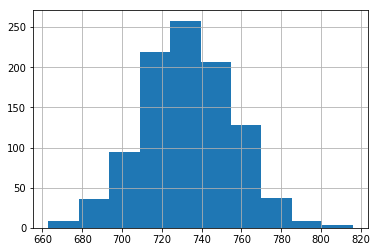

In [69]:
team_totals_samples_df.points.hist();